In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

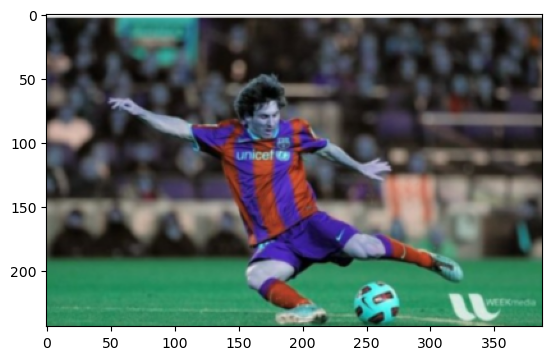

(<matplotlib.image.AxesImage at 0x265d9713250>, None)

In [7]:
img = cv.imread('IM/M5.jpg')
assert img is not None, "file could not be read, check with os.path.exists()"
lower_reso = cv.pyrDown(img)
plt.imshow(lower_reso), plt.show()

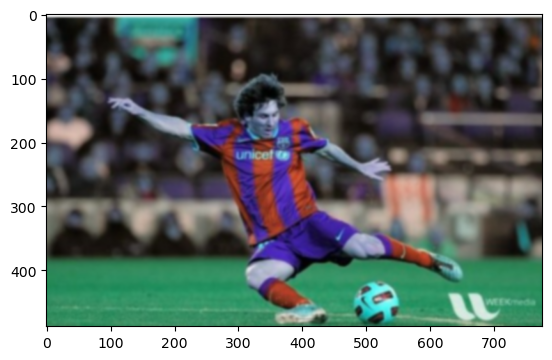

(<matplotlib.image.AxesImage at 0x265daa09490>, None)

In [8]:
higher_reso2  = cv.pyrUp(lower_reso)
plt.imshow(higher_reso2), plt.show()

In [35]:
import cv2 as cv
import numpy as np,sys
A = cv.imread('IM/or.png')
B = cv.imread('IM/ap.webp')
assert A is not None, "file could not be read, check with os.path.exists()"
assert B is not None, "file could not be read, check with os.path.exists()"
print(A.shape)
print(B.shape)
# generate Gaussian pyramid for A
G = A.copy()
gpA = [G]
for i in range(6):
    G = cv.pyrDown(G)
    gpA.append(G)
# generate Gaussian pyramid for B
G = B.copy()
gpB = [G]
for i in range(6):
    G = cv.pyrDown(G)
    gpB.append(G)
# generate Laplacian Pyramid for A
lpA = [gpA[5]]
for i in range(5,0,-1):
    GE = cv.pyrUp(gpA[i])
    L = cv.subtract(gpA[i-1],GE)
    lpA.append(L)
# generate Laplacian Pyramid for B
lpB = [gpB[5]]
for i in range(5,0,-1):
    GE = cv.pyrUp(gpB[i])
    L = cv.subtract(gpB[i-1],GE)
    lpB.append(L)
# Now add left and right halves of images in each level
LS = []
for la,lb in zip(lpA,lpB):
    rows,cols,dpt = la.shape
    ls = np.hstack((la[:,0:cols//2], lb[:,cols//2:]))
    LS.append(ls)
# now reconstruct
ls_ = LS[0]
for i in range(1,6):
    ls_ = cv.pyrUp(ls_)
    ls_ = cv.add(ls_, LS[i])
# image with direct connecting each half
real = np.hstack((A[:,:cols//2],B[:,cols//2:]))
cv.imshow('Pyramid_blending2.jpg',ls_)
cv.imshow('Direct_blending.jpg',real)

(800, 800, 3)
(800, 800, 3)


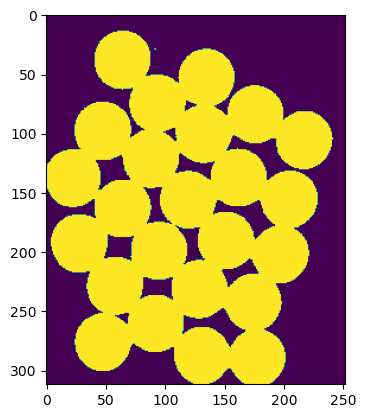

(<matplotlib.image.AxesImage at 0x2991bf85450>, None)

In [3]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv.imread('IM/M.jpg')
assert img is not None, "file could not be read, check with os.path.exists()"
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
plt.imshow(thresh), plt.show()

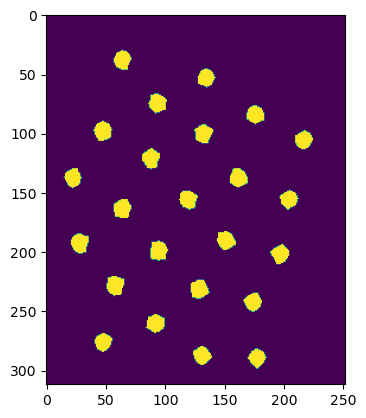

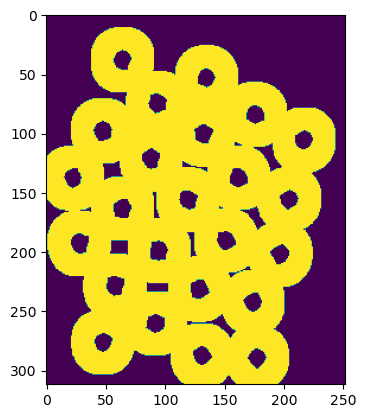

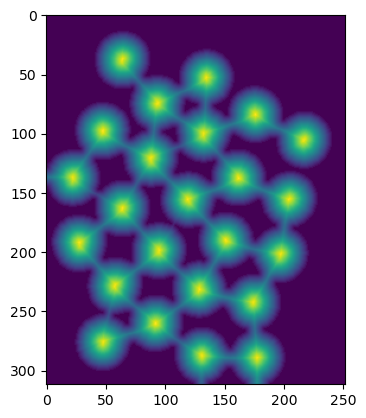

(<matplotlib.image.AxesImage at 0x2991ed49dd0>, None)

In [9]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

plt.imshow(sure_fg), plt.show()
plt.imshow(unknown), plt.show()
plt.imshow(dist_transform), plt.show()

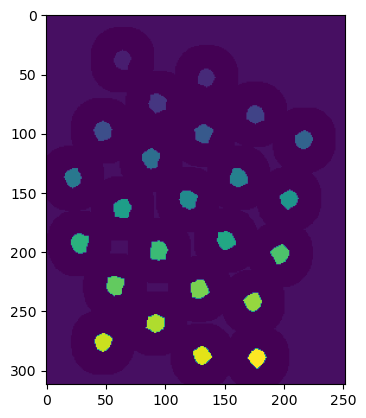

(<matplotlib.image.AxesImage at 0x2991fed2c90>, None)

In [11]:
# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
plt.imshow(markers), plt.show()

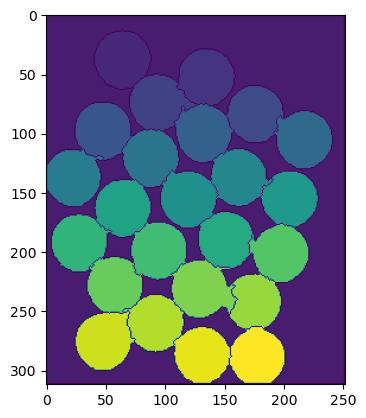

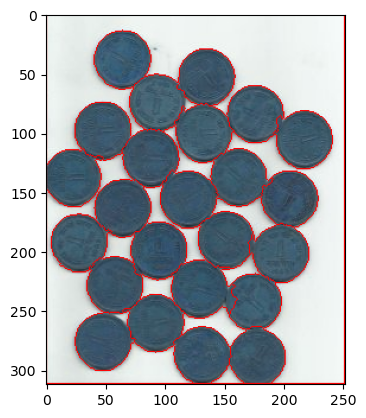

(<matplotlib.image.AxesImage at 0x2991ed60890>, None)

In [13]:
markers = cv.watershed(img,markers)
img[markers == -1] = [255,0,0]
plt.imshow(markers), plt.show()
plt.imshow(img), plt.show()

In [17]:
from __future__ import print_function
import sys

import cv2 as cv
import numpy as np


def print_help():
    print('''
    This program demonstrated the use of the discrete Fourier transform (DFT).
    The dft of an image is taken and it's power spectrum is displayed.
    Usage:
    discrete_fourier_transform.py [image_name -- default lena.jpg]''')


def main(argv):

    print_help()

    filename = 'IM/FL1.jpg'

    I = cv.imread(cv.samples.findFile(filename), cv.IMREAD_GRAYSCALE)
    if I is None:
        print('Error opening image')
        return -1
    ## [expand]
    rows, cols = I.shape
    m = cv.getOptimalDFTSize( rows )
    n = cv.getOptimalDFTSize( cols )
    padded = cv.copyMakeBorder(I, 0, m - rows, 0, n - cols, cv.BORDER_CONSTANT, value=[0, 0, 0])
    ## [expand]
    ## [complex_and_real]
    planes = [np.float32(padded), np.zeros(padded.shape, np.float32)]
    complexI = cv.merge(planes)         # Add to the expanded another plane with zeros
    ## [complex_and_real]
    ## [dft]
    cv.dft(complexI, complexI)         # this way the result may fit in the source matrix
    ## [dft]
    # compute the magnitude and switch to logarithmic scale
    # = > log(1 + sqrt(Re(DFT(I)) ^ 2 + Im(DFT(I)) ^ 2))
    ## [magnitude]
    cv.split(complexI, planes)                   # planes[0] = Re(DFT(I), planes[1] = Im(DFT(I))
    cv.magnitude(planes[0], planes[1], planes[0])# planes[0] = magnitude
    magI = planes[0]
    ## [magnitude]
    ## [log]
    matOfOnes = np.ones(magI.shape, dtype=magI.dtype)
    cv.add(matOfOnes, magI, magI) #  switch to logarithmic scale
    cv.log(magI, magI)
    ## [log]
    ## [crop_rearrange]
    magI_rows, magI_cols = magI.shape
    # crop the spectrum, if it has an odd number of rows or columns
    magI = magI[0:(magI_rows & -2), 0:(magI_cols & -2)]
    cx = int(magI_rows/2)
    cy = int(magI_cols/2)

    q0 = magI[0:cx, 0:cy]         # Top-Left - Create a ROI per quadrant
    q1 = magI[cx:cx+cx, 0:cy]     # Top-Right
    q2 = magI[0:cx, cy:cy+cy]     # Bottom-Left
    q3 = magI[cx:cx+cx, cy:cy+cy] # Bottom-Right

    tmp = np.copy(q0)               # swap quadrants (Top-Left with Bottom-Right)
    magI[0:cx, 0:cy] = q3
    magI[cx:cx + cx, cy:cy + cy] = tmp

    tmp = np.copy(q1)               # swap quadrant (Top-Right with Bottom-Left)
    magI[cx:cx + cx, 0:cy] = q2
    magI[0:cx, cy:cy + cy] = tmp
    ## [crop_rearrange]
    ## [normalize]
    cv.normalize(magI, magI, 0, 1, cv.NORM_MINMAX) # Transform the matrix with float values into a
    ## viewable image form(float between values 0 and 1).
    ## [normalize]
    cv.imshow("Input Image"       , I   )    # Show the result
    cv.imshow("spectrum magnitude", magI)
    cv.waitKey()

if __name__ == "__main__":
    main(sys.argv[1:])


    This program demonstrated the use of the discrete Fourier transform (DFT).
    The dft of an image is taken and it's power spectrum is displayed.
    Usage:
    discrete_fourier_transform.py [image_name -- default lena.jpg]
